In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
ROOT_PATH='/content/drive/My Drive/Colab Notebooks/zero_DL/deep-learning-from-scratch'
sys.path.append(ROOT_PATH)

Mounted at /content/drive


In [ ]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import pickle
import numpy as np
from collections import OrderedDict
from common.layers import *

class DeepConvNet:
    '''
    conv-relu-conv-relu-pool-
    conv-relu-conv-relu-pool-
    conv-relu-conv-relu-pool-
    affine-relu-dropout-
    affine-dropout-softmax
    '''
    def __init__(self,input_dim=(1,28,28),
               conv_param_1={'filter_num':16,'filter_size':3,'pad':1,'stride':1},
               conv_param_2={'filter_num':16,'filter_size':3,'pad':1,'stride':1},
               conv_param_3={'filter_num':32,'filter_size':3,'pad':1,'stride':1},
               conv_param_4={'filter_num':32,'filter_size':3,'pad':2,'stride':1},
               conv_param_5={'filter_num':64,'filter_size':3,'pad':1,'stride':1},
               conv_param_6={'filter_num':64,'filter_size':3,'pad':1,'stride':1},
               hidden_size=50,output_size=10):  #poolingで画像サイズを小さくしたら、出力のチャンネル数（＝フィルタの数）を倍にすると良い（VGG16の論文で示された）
        
        pre_channel_num=input_dim[0]  #前の層の出力のチャンネル数
        out_size=input_dim[1] #現在の層の出力のサイズ（全結合層への入力サイズ導出に使用）
        self.params={}

        #Conv層のパラメータ
        for idx,conv_param in enumerate([conv_param_1,conv_param_2,conv_param_3,conv_param_4,
                        conv_param_5,conv_param_6]):
            pre_node_num=pre_channel_num*conv_param['filter_size']*conv_param['filter_size']    #前の層のノード数
            weight_init_scale=np.sqrt(2/pre_node_num) #Heの初期値
            self.params['W'+str(idx+1)]=\
                weight_init_scale*np.random.randn(conv_param['filter_num'],
                                                  pre_channel_num,conv_param['filter_size'],
                                                  conv_param['filter_size'])    #W(FN,FH,FW)
            self.params['b'+str(idx+1)]=np.zeros(conv_param['filter_num'])  #b(FN)

            pre_channel_num=conv_param['filter_num']

            out_size=int((out_size+2*conv_param['pad']-conv_param['filter_size'])/conv_param['stride']+1)
            if idx in (1,3,5):  #Conv2,4,6後にはPoolingによりサイズを半分にする
                out_size//=2
            # print(out_size)

        #全結合層(affine)のパラメータ
        pre_node_num=conv_param_6['filter_num']*out_size*out_size
        weight_init_scale=np.sqrt(2/pre_node_num) #Heの初期値
        self.params['W7']=weight_init_scale*np.random.randn(pre_node_num,hidden_size)
        self.params['b7']=np.zeros(hidden_size)

        pre_node_num=hidden_size
        weight_init_scale=np.sqrt(2/pre_node_num) #Heの初期値
        self.params['W8']=weight_init_scale*np.random.randn(hidden_size,output_size)
        self.params['b8']=np.zeros(output_size)
        # print(self.params.keys())

        #Layerの生成
        self.layers=[]
        self.layers.append(Convolution(self.params['W1'],self.params['b1'],conv_param_1['stride'],conv_param_1['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W2'],self.params['b2'],conv_param_2['stride'],conv_param_2['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2,pool_w=2,stride=2,pad=0))
        self.layers.append(Convolution(self.params['W3'],self.params['b3'],conv_param_3['stride'],conv_param_3['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W4'],self.params['b4'],conv_param_4['stride'],conv_param_4['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2,pool_w=2,stride=2,pad=0))
        self.layers.append(Convolution(self.params['W5'],self.params['b5'],conv_param_5['stride'],conv_param_5['pad']))
        self.layers.append(Relu())
        self.layers.append(Convolution(self.params['W6'],self.params['b6'],conv_param_6['stride'],conv_param_6['pad']))
        self.layers.append(Relu())
        self.layers.append(Pooling(pool_h=2,pool_w=2,stride=2,pad=0))
        self.layers.append(Affine(self.params['W7'],self.params['b7']))
        self.layers.append(Relu())
        self.layers.append(Dropout())
        self.layers.append(Affine(self.params['W8'],self.params['b8']))
        self.layers.append(Dropout())

        self.last_layer=SoftmaxWithLoss()

    def predict(self, x, train_flg=False):
        for layer in self.layers:
            if isinstance(layer, Dropout):  #layerがDropoutの場合は引数にtrain_flagを与える
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)
        return x

    def loss(self, x, t):
        y = self.predict(x, train_flg=True)
        return self.last_layer.forward(y, t)

    def accuracy(self, x, t, batch_size=100):
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        acc = 0.0

        for i in range(int(x.shape[0] / batch_size)):
            tx = x[i*batch_size:(i+1)*batch_size]
            tt = t[i*batch_size:(i+1)*batch_size]
            y = self.predict(tx, train_flg=False)
            y = np.argmax(y, axis=1)
            acc += np.sum(y == tt)

        return acc / x.shape[0]

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        tmp_layers = self.layers.copy() #Layerリストをコピー（コピーしないでreverseするとリストの場合はもとのリストもreverseする）
        tmp_layers.reverse()
        for layer in tmp_layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):    #Conv層とAffine層の勾配を格納
            grads['W' + str(i+1)] = self.layers[layer_idx].dW
            grads['b' + str(i+1)] = self.layers[layer_idx].db

        return grads

    def save_params(self, file_name="params.pkl"):
        params = {}
        for key, val in self.params.items():
            params[key] = val
        with open(file_name, 'wb') as f:
            pickle.dump(params, f)

    def load_params(self, file_name="params.pkl"):
        with open(file_name, 'rb') as f:
            params = pickle.load(f)
        for key, val in params.items():
            self.params[key] = val

        for i, layer_idx in enumerate((0, 2, 5, 7, 10, 12, 15, 18)):    #Conv層とAffine層のパラメータをレイヤーに読み込み
            self.layers[layer_idx].W = self.params['W' + str(i+1)]
            self.layers[layer_idx].b = self.params['b' + str(i+1)]

### GPU対応

In [ ]:
from common import config
config.GPU=True

from dataset.mnist import load_mnist
from ch08.deep_convnet2 import DeepConvNet2
from common.trainer import Trainer
from common.util import *

(x_train,t_train),(x_test,t_test)=load_mnist(flatten=False)

if GPU:
    x_train=to_gpu(x_train)
    t_train=to_gpu(t_train)
    x_test=to_gpu(x_test)
    t_test=to_gpu(t_test)

network=DeepConvNet2()
trainer=Trainer(network,x_train,t_train,x_test,t_test,epochs=20,mini_batch_size=100,
                optimizer='Adam',optimizer_param={'lr':0.01},
                evaluate_sample_num_per_epoch=1000,verbose=True)

trainer.train()

# パラメータの保存
network.save_params(ROOT_PATH+"/ch08/deep_convnet2_params.pkl")
print("Saved Network Parameters!")

ストリーミング出力は最後の 5000 行に切り捨てられました。
train loss:0.7826276305566958
train loss:0.9254890385415893
train loss:0.8877206863123882
train loss:1.0726709793245053
train loss:0.9092229273998749
train loss:0.9142282666132481
train loss:0.9202373895985386
train loss:0.8785146234508651
train loss:1.1577089012457185
train loss:1.0125708134681946
train loss:0.9777843630198189
train loss:0.8659995168797872
train loss:0.910410539665252
train loss:0.9541043659473735
train loss:1.2304378347809568
train loss:0.8565122565389425
train loss:1.046603133134762
train loss:0.8231071777101729
train loss:1.2041847251939886
train loss:0.8665829682131396
train loss:0.8308635132291016
train loss:0.9411460613751476
train loss:0.8700198295370023
train loss:0.8581421872251095
train loss:1.0421685251409152
train loss:0.9790346915632111
train loss:0.9155280903977772
train loss:0.9789039739400858
train loss:0.9714598657883756
train loss:0.8356523279475732
train loss:1.011314928732003
train loss:0.8209445261338288
train loss:

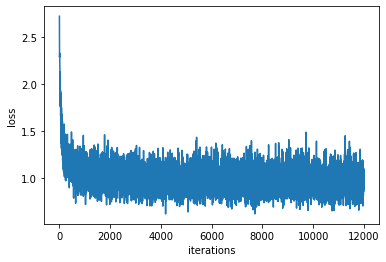

In [ ]:
trainer.plot()

2382


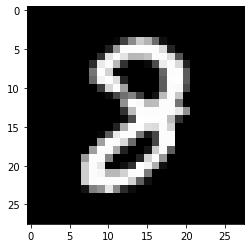

[8]
8


In [ ]:
import numpy as np
from ch08.deep_convnet2 import DeepConvNet2
from dataset.mnist import load_mnist
import matplotlib.pyplot as plt

model=DeepConvNet2()
model.load_params(ROOT_PATH+"/ch08/deep_convnet2_params.pkl")
# print(type(model.params['W1']))

(x_train,t_train),(x_test,t_test)=load_mnist(flatten=False)
id=np.random.randint(len(x_test))
print(id)
plt.gray()
plt.imshow(x_test[id].reshape(28,28))
plt.show()
score=model.predict(x_test[id].reshape(1,1,28,28))
predict_label=np.argmax(score,axis=1)
print(predict_label)
print(t_test[id])

### Grobal Average Pooling

In [ ]:
class GAP:
    def __init__(self):
        self.cache=None

    def forward(self,x):
        N,C,H,W=x.shape
        x=x.reshape(N,C,-1) #(N,C,H*W)
        out=np.mean(x,axis=-1)    #(N,C)
        self.cache=(N,C,H,W)

        return out

    def backward(self,dout):
        N,C,H,W=self.cache
        dout=1/(H*W)*dout
        dx=dout.reshape(N,C,1).repeat(H*W,axis=2)
        dx=dx.reshape(N,C,H,-1)

        return dx        

In [ ]:
from common import config
config.GPU=True

from dataset.mnist import load_mnist
from ch08.deep_convnet3 import DeepConvNet3
from common.trainer import Trainer
from common.util import *

(x_train,t_train),(x_test,t_test)=load_mnist(flatten=False)

if GPU:
    x_train=to_gpu(x_train)
    t_train=to_gpu(t_train)
    x_test=to_gpu(x_test)
    t_test=to_gpu(t_test)

network=DeepConvNet3()
trainer=Trainer(network,x_train,t_train,x_test,t_test,epochs=20,mini_batch_size=100,
                optimizer='Adam',optimizer_param={'lr':0.01},
                evaluate_sample_num_per_epoch=1000,verbose=True)

trainer.train()

# パラメータの保存
network.save_params(ROOT_PATH+"/ch08/deep_convnet3_params.pkl")
print("Saved Network Parameters!")

ストリーミング出力は最後の 5000 行に切り捨てられました。
train loss:0.01956627185467511
train loss:0.03581996720660066
train loss:0.013923514163600256
train loss:0.10058870300016919
train loss:0.002184352958853083
train loss:0.00798210651655693
train loss:0.01083861308541937
train loss:0.009728155789814796
train loss:0.0038547000502858393
train loss:0.002073124240663332
train loss:0.011204389568803095
train loss:0.001886479198599298
train loss:0.0071084806866702
train loss:0.016607234421405395
train loss:0.03630415720237343
train loss:0.02288550654708524
train loss:0.01954498063223768
train loss:0.015193663117639302
train loss:0.0057727198722341755
train loss:0.0212851316567268
train loss:0.005130399887785308
train loss:0.010667684019776868
train loss:0.007423802844945373
train loss:0.03451533268529941
train loss:0.013456659547059427
train loss:0.012157613560777334
train loss:0.04067591921689748
train loss:0.007499258259496873
train loss:0.001005929692064553
train loss:0.004889010073767166
train loss:0.0546644

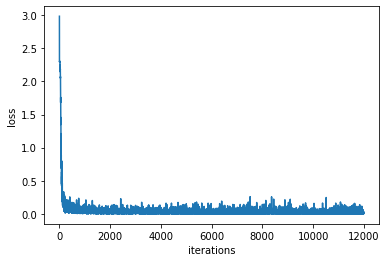

In [ ]:
trainer.plot()

8382


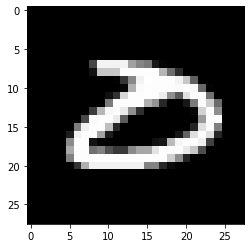

[0]
0


In [ ]:
import numpy as np
from ch08.deep_convnet3 import DeepConvNet3
from dataset.mnist import load_mnist
import matplotlib.pyplot as plt

model=DeepConvNet3()
model.load_params(ROOT_PATH+"/ch08/deep_convnet3_params.pkl")
# print(type(model.params['W1']))

(x_train,t_train),(x_test,t_test)=load_mnist(flatten=False)
id=np.random.randint(len(x_test))
print(id)
plt.gray()
plt.imshow(x_test[id].reshape(28,28))
plt.show()
score=model.predict(x_test[id].reshape(1,1,28,28))
predict_label=np.argmax(score,axis=1)
print(predict_label)
print(t_test[id])

In [2]:
!pip install dlt

In [3]:
from common import config
# config.GPU=True

import dlt
from ch08.deep_convnet3 import DeepConvNet3
from common.trainer import Trainer
from common.util import *

data = dlt.cifar.load_cifar10()

x_train=data.train_images.transpose(0,3,1,2).astype('f')
x_train/=255.
t_train=data.train_labels

x_test=data.test_images.transpose(0,3,1,2).astype('f')
x_test/=255.
t_test=data.test_labels

if GPU:
    x_train=to_gpu(x_train)
    t_train=to_gpu(t_train)
    x_test=to_gpu(x_test)
    t_test=to_gpu(t_test)

network=DeepConvNet3(input_dim=(3,32,32))
trainer=Trainer(network,x_train,t_train,x_test,t_test,epochs=20,mini_batch_size=100,
                optimizer='Adam',optimizer_param={'lr':0.01},
                evaluate_sample_num_per_epoch=1000,verbose=True)

trainer.train()

# パラメータの保存
network.save_params(ROOT_PATH+"/ch08/deep_convnet3_cifar10.pkl")
print("Saved Network Parameters!")

170500096/170498071 [==============================] - 11s 0us/step
train loss:263.4155760001436
=== epoch:1, train acc:1.0, test acc:1.0 ===
train loss:1431.9083767933453
train loss:1498.9828948391232
train loss:1370.038128831457
train loss:1434.5105118352903
train loss:1531.21908634104
train loss:1531.21908634104
train loss:1498.9828948391234
train loss:1386.1562245824152
train loss:1450.6286075862486
train loss:1531.21908634104
train loss:1482.8647990881652
train loss:1498.9828948391234
train loss:1498.9828948391234
train loss:1519.4862526338145
train loss:1498.9828948391234
train loss:1370.038128831457
train loss:1402.2743203333737
train loss:1454.1745886514595
train loss:1353.9200330804988
train loss:1402.2743203333737
train loss:1418.392416084332
train loss:1434.5105118352903
train loss:1402.2743203333737
train loss:1450.6286075862486
train loss:1450.6286075862486
train loss:1466.7467033372068
train loss:1531.21908634104
train loss:1450.6286075862486
train loss:1466.7467033372068

KeyboardInterrupt: ignored